# Optimized Data Set Dimensionality Study with Parameters

In [1]:
#imports and loads

import seaborn as sns
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


coord = np.load('airfoils_opt.npy')
aoa = np.load('aoas_opt.npy')
inputs = np.load('inp_paras.npy')

data = np.hstack((aoa.reshape(-1,1), inputs[:,0].reshape(-1,1)))
data = np.hstack((data, inputs[:,1].reshape(-1,1)))
data = np.hstack((data, inputs[:,2].reshape(-1,1)))
data = np.hstack((data, coord.reshape(1042,384)))

cor = np.arange(0,388,1)
df = pd.DataFrame(data, columns = [cor])


#Scaling
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)
scaleddf = pd.DataFrame(scaled, columns = [cor])


#Use GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

num = 25
comp = 4
test_size = 0.2
train_size = (1-test_size)*1042
ts = 1042 - train_size
X_train = np.zeros((num, int(test_size),388), dtype=float)
X_test = np.zeros((num, int(ts), 388), dtype=float)


Using cuda device


In [2]:
class Autoencoder(nn.Module):
    """

    Parameters
    ----------
    in_shape [int] : input shape
    enc_shape [int] : desired encoded shape
    """

    def __init__(self, in_shape, enc_shape):
        super(Autoencoder, self).__init__()
        
        self.encode = nn.Sequential(
            nn.Linear(in_shape, 388),
            nn.ReLU(True),
            nn.Linear(388, enc_shape),
        )
        
        self.decode = nn.Sequential(
            nn.BatchNorm1d(enc_shape),
            nn.Linear(enc_shape, 388),
            nn.ReLU(True),
            nn.Linear(388, in_shape)
        )
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [3]:
def train(model, error, optimizer, n_epochs, x):
    model.train()
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        output = model(x)
        error = nn.MSELoss()
        loss = error(output, x)
        loss.backward()
        optimizer.step()
        
        if epoch % int(0.05*n_epochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')

In [4]:
num = 25 #number of training-testing splits
dim = 20 #latent space size
MSE_TRAIN = np.zeros((dim, num), dtype=float)
MSE_TEST = np.zeros((dim, num), dtype=float)
RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
output = np.zeros((dim, num, int(train_size),388), dtype=float)
output_y = np.zeros((dim, num, math.ceil(ts),388), dtype=float)


def complete_train_test(n_epochs, scaled, num):
    for i in range(1,dim+1):
        encoder = Autoencoder(in_shape=388, enc_shape=i).double().to(device)
        error = nn.MSELoss()
        learning_rate = 0.0001
        optimizer = optim.Adam(encoder.parameters(),lr=learning_rate, weight_decay=0)
    
        for j in range(num):
            x, y = train_test_split(scaled, test_size=test_size, shuffle=True)
            train(encoder, error, optimizer, n_epochs, torch.from_numpy(x).to(device))
        
            output[i-1][j] = encoder(torch.from_numpy(x).to(device)).detach().cpu().numpy()
            output_y[i-1][j] = encoder(torch.from_numpy(y).to(device)).detach().cpu().numpy()
            
            MSE_TRAIN[i-1][j] = mean_squared_error(x, output[i-1][j])
            MSE_TEST[i-1][j] = mean_squared_error(y, output_y[i-1][j])
            
            RE[i-1][j] = ((output_y[i-1][j] - y)**2).mean(axis=1)
            print(f'\nLatent Space Size: {i}   \nIteration: {j}')
    print(f'\nMSE TEST: {MSE_TEST} \nMSE TRAIN: {MSE_TRAIN}\n\n')

In [5]:
%%time
complete_train_test(1000, scaled, num)
#Assumes the learning rate is constant

epoch 50 	 Loss: 0.07711
epoch 100 	 Loss: 0.0334
epoch 150 	 Loss: 0.02773
epoch 200 	 Loss: 0.02568
epoch 250 	 Loss: 0.02413
epoch 300 	 Loss: 0.02284
epoch 350 	 Loss: 0.02176
epoch 400 	 Loss: 0.02081
epoch 450 	 Loss: 0.0199
epoch 500 	 Loss: 0.01893
epoch 550 	 Loss: 0.01788
epoch 600 	 Loss: 0.0168
epoch 650 	 Loss: 0.01587
epoch 700 	 Loss: 0.01486
epoch 750 	 Loss: 0.01407
epoch 800 	 Loss: 0.01343
epoch 850 	 Loss: 0.01287
epoch 900 	 Loss: 0.01239
epoch 950 	 Loss: 0.01194
epoch 1000 	 Loss: 0.01151

Latent Space Size: 1   
Iteration: 0
epoch 50 	 Loss: 0.01095
epoch 100 	 Loss: 0.01056
epoch 150 	 Loss: 0.01014
epoch 200 	 Loss: 0.00975
epoch 250 	 Loss: 0.009438
epoch 300 	 Loss: 0.009022
epoch 350 	 Loss: 0.008674
epoch 400 	 Loss: 0.008361
epoch 450 	 Loss: 0.008005
epoch 500 	 Loss: 0.007668
epoch 550 	 Loss: 0.007376
epoch 600 	 Loss: 0.007121
epoch 650 	 Loss: 0.006881
epoch 700 	 Loss: 0.006678
epoch 750 	 Loss: 0.006578
epoch 800 	 Loss: 0.006316
epoch 850 	 Loss: 

epoch 350 	 Loss: 0.001717
epoch 400 	 Loss: 0.001712
epoch 450 	 Loss: 0.001709
epoch 500 	 Loss: 0.001704
epoch 550 	 Loss: 0.001706
epoch 600 	 Loss: 0.001709
epoch 650 	 Loss: 0.001696
epoch 700 	 Loss: 0.001694
epoch 750 	 Loss: 0.001694
epoch 800 	 Loss: 0.00169
epoch 850 	 Loss: 0.001686
epoch 900 	 Loss: 0.001697
epoch 950 	 Loss: 0.001682
epoch 1000 	 Loss: 0.001687

Latent Space Size: 1   
Iteration: 14
epoch 50 	 Loss: 0.001591
epoch 100 	 Loss: 0.001587
epoch 150 	 Loss: 0.001586
epoch 200 	 Loss: 0.001589
epoch 250 	 Loss: 0.001582
epoch 300 	 Loss: 0.001577
epoch 350 	 Loss: 0.001579
epoch 400 	 Loss: 0.001573
epoch 450 	 Loss: 0.001577
epoch 500 	 Loss: 0.001574
epoch 550 	 Loss: 0.001573
epoch 600 	 Loss: 0.001568
epoch 650 	 Loss: 0.001561
epoch 700 	 Loss: 0.001562
epoch 750 	 Loss: 0.001558
epoch 800 	 Loss: 0.001562
epoch 850 	 Loss: 0.001563
epoch 900 	 Loss: 0.001557
epoch 950 	 Loss: 0.001561
epoch 1000 	 Loss: 0.001559

Latent Space Size: 1   
Iteration: 15
epoc

epoch 600 	 Loss: 0.001337
epoch 650 	 Loss: 0.001328
epoch 700 	 Loss: 0.00132
epoch 750 	 Loss: 0.001312
epoch 800 	 Loss: 0.001305
epoch 850 	 Loss: 0.001297
epoch 900 	 Loss: 0.001286
epoch 950 	 Loss: 0.001279
epoch 1000 	 Loss: 0.001267

Latent Space Size: 2   
Iteration: 3
epoch 50 	 Loss: 0.00123
epoch 100 	 Loss: 0.001222
epoch 150 	 Loss: 0.001208
epoch 200 	 Loss: 0.001195
epoch 250 	 Loss: 0.00118
epoch 300 	 Loss: 0.001168
epoch 350 	 Loss: 0.001155
epoch 400 	 Loss: 0.001147
epoch 450 	 Loss: 0.001129
epoch 500 	 Loss: 0.001119
epoch 550 	 Loss: 0.001109
epoch 600 	 Loss: 0.001094
epoch 650 	 Loss: 0.001081
epoch 700 	 Loss: 0.00107
epoch 750 	 Loss: 0.001061
epoch 800 	 Loss: 0.001049
epoch 850 	 Loss: 0.001044
epoch 900 	 Loss: 0.001033
epoch 950 	 Loss: 0.001022
epoch 1000 	 Loss: 0.001017

Latent Space Size: 2   
Iteration: 4
epoch 50 	 Loss: 0.001156
epoch 100 	 Loss: 0.001143
epoch 150 	 Loss: 0.001133
epoch 200 	 Loss: 0.001128
epoch 250 	 Loss: 0.001116
epoch 300 

epoch 450 	 Loss: 0.0004149
epoch 500 	 Loss: 0.0004104
epoch 550 	 Loss: 0.0004118
epoch 600 	 Loss: 0.000412
epoch 650 	 Loss: 0.0004142
epoch 700 	 Loss: 0.0004068
epoch 750 	 Loss: 0.0004091
epoch 800 	 Loss: 0.0004059
epoch 850 	 Loss: 0.0004024
epoch 900 	 Loss: 0.0004042
epoch 950 	 Loss: 0.0004029
epoch 1000 	 Loss: 0.0004028

Latent Space Size: 2   
Iteration: 17
epoch 50 	 Loss: 0.0004055
epoch 100 	 Loss: 0.0004001
epoch 150 	 Loss: 0.0004021
epoch 200 	 Loss: 0.0003982
epoch 250 	 Loss: 0.0003972
epoch 300 	 Loss: 0.0003952
epoch 350 	 Loss: 0.0003979
epoch 400 	 Loss: 0.0003931
epoch 450 	 Loss: 0.0003898
epoch 500 	 Loss: 0.0003934
epoch 550 	 Loss: 0.0003914
epoch 600 	 Loss: 0.0003908
epoch 650 	 Loss: 0.0003865
epoch 700 	 Loss: 0.0003861
epoch 750 	 Loss: 0.0003892
epoch 800 	 Loss: 0.0003892
epoch 850 	 Loss: 0.0003901
epoch 900 	 Loss: 0.0003825
epoch 950 	 Loss: 0.0003862
epoch 1000 	 Loss: 0.0003847

Latent Space Size: 2   
Iteration: 18
epoch 50 	 Loss: 0.0004029

epoch 250 	 Loss: 0.0004547
epoch 300 	 Loss: 0.000447
epoch 350 	 Loss: 0.0004378
epoch 400 	 Loss: 0.0004292
epoch 450 	 Loss: 0.0004214
epoch 500 	 Loss: 0.0004175
epoch 550 	 Loss: 0.0004124
epoch 600 	 Loss: 0.0004023
epoch 650 	 Loss: 0.0003975
epoch 700 	 Loss: 0.0003922
epoch 750 	 Loss: 0.0003913
epoch 800 	 Loss: 0.0003875
epoch 850 	 Loss: 0.00038
epoch 900 	 Loss: 0.0003805
epoch 950 	 Loss: 0.0003743
epoch 1000 	 Loss: 0.0003686

Latent Space Size: 3   
Iteration: 6
epoch 50 	 Loss: 0.0003829
epoch 100 	 Loss: 0.0003763
epoch 150 	 Loss: 0.0003714
epoch 200 	 Loss: 0.0003686
epoch 250 	 Loss: 0.0003648
epoch 300 	 Loss: 0.0003662
epoch 350 	 Loss: 0.0003619
epoch 400 	 Loss: 0.0003559
epoch 450 	 Loss: 0.0003599
epoch 500 	 Loss: 0.0003488
epoch 550 	 Loss: 0.0003461
epoch 600 	 Loss: 0.000346
epoch 650 	 Loss: 0.0003398
epoch 700 	 Loss: 0.000342
epoch 750 	 Loss: 0.0003384
epoch 800 	 Loss: 0.0003375
epoch 850 	 Loss: 0.0003327
epoch 900 	 Loss: 0.0003287
epoch 950 	 Los

epoch 50 	 Loss: 0.0001639
epoch 100 	 Loss: 0.000162
epoch 150 	 Loss: 0.0001613
epoch 200 	 Loss: 0.0001616
epoch 250 	 Loss: 0.0001609
epoch 300 	 Loss: 0.0001623
epoch 350 	 Loss: 0.0001594
epoch 400 	 Loss: 0.0001605
epoch 450 	 Loss: 0.0001601
epoch 500 	 Loss: 0.0001619
epoch 550 	 Loss: 0.0001609
epoch 600 	 Loss: 0.0001587
epoch 650 	 Loss: 0.0001638
epoch 700 	 Loss: 0.0001578
epoch 750 	 Loss: 0.0001592
epoch 800 	 Loss: 0.0001585
epoch 850 	 Loss: 0.0001586
epoch 900 	 Loss: 0.000157
epoch 950 	 Loss: 0.0001606
epoch 1000 	 Loss: 0.0001573

Latent Space Size: 3   
Iteration: 20
epoch 50 	 Loss: 0.0001569
epoch 100 	 Loss: 0.0001563
epoch 150 	 Loss: 0.0001557
epoch 200 	 Loss: 0.0001573
epoch 250 	 Loss: 0.0001563
epoch 300 	 Loss: 0.000153
epoch 350 	 Loss: 0.0001527
epoch 400 	 Loss: 0.0001541
epoch 450 	 Loss: 0.0001552
epoch 500 	 Loss: 0.0001516
epoch 550 	 Loss: 0.0001523
epoch 600 	 Loss: 0.0001521
epoch 650 	 Loss: 0.0001532
epoch 700 	 Loss: 0.0001577
epoch 750 	 L

epoch 950 	 Loss: 0.000204
epoch 1000 	 Loss: 0.0002032

Latent Space Size: 4   
Iteration: 8
epoch 50 	 Loss: 0.0002159
epoch 100 	 Loss: 0.0002128
epoch 150 	 Loss: 0.0002156
epoch 200 	 Loss: 0.0002118
epoch 250 	 Loss: 0.0002101
epoch 300 	 Loss: 0.0002197
epoch 350 	 Loss: 0.0002079
epoch 400 	 Loss: 0.0002061
epoch 450 	 Loss: 0.0002038
epoch 500 	 Loss: 0.0002021
epoch 550 	 Loss: 0.0002007
epoch 600 	 Loss: 0.0001984
epoch 650 	 Loss: 0.0002013
epoch 700 	 Loss: 0.0001976
epoch 750 	 Loss: 0.0001924
epoch 800 	 Loss: 0.0001906
epoch 850 	 Loss: 0.0001914
epoch 900 	 Loss: 0.000189
epoch 950 	 Loss: 0.0001909
epoch 1000 	 Loss: 0.0001875

Latent Space Size: 4   
Iteration: 9
epoch 50 	 Loss: 0.0001876
epoch 100 	 Loss: 0.0001867
epoch 150 	 Loss: 0.0001865
epoch 200 	 Loss: 0.0001846
epoch 250 	 Loss: 0.0001846
epoch 300 	 Loss: 0.0001842
epoch 350 	 Loss: 0.00018
epoch 400 	 Loss: 0.000178
epoch 450 	 Loss: 0.0001766
epoch 500 	 Loss: 0.000176
epoch 550 	 Loss: 0.0001758
epoch 

epoch 700 	 Loss: 7.845e-05
epoch 750 	 Loss: 7.853e-05
epoch 800 	 Loss: 7.87e-05
epoch 850 	 Loss: 8.028e-05
epoch 900 	 Loss: 7.886e-05
epoch 950 	 Loss: 7.55e-05
epoch 1000 	 Loss: 8.038e-05

Latent Space Size: 4   
Iteration: 22
epoch 50 	 Loss: 8.476e-05
epoch 100 	 Loss: 8.54e-05
epoch 150 	 Loss: 8.316e-05
epoch 200 	 Loss: 8.388e-05
epoch 250 	 Loss: 8.243e-05
epoch 300 	 Loss: 8.172e-05
epoch 350 	 Loss: 8.125e-05
epoch 400 	 Loss: 8.336e-05
epoch 450 	 Loss: 8.073e-05
epoch 500 	 Loss: 8.168e-05
epoch 550 	 Loss: 8.572e-05
epoch 600 	 Loss: 7.984e-05
epoch 650 	 Loss: 8.024e-05
epoch 700 	 Loss: 8.214e-05
epoch 750 	 Loss: 8.049e-05
epoch 800 	 Loss: 7.995e-05
epoch 850 	 Loss: 8.147e-05
epoch 900 	 Loss: 7.977e-05
epoch 950 	 Loss: 8.024e-05
epoch 1000 	 Loss: 8.265e-05

Latent Space Size: 4   
Iteration: 23
epoch 50 	 Loss: 8.333e-05
epoch 100 	 Loss: 7.942e-05
epoch 150 	 Loss: 7.827e-05
epoch 200 	 Loss: 7.816e-05
epoch 250 	 Loss: 7.823e-05
epoch 300 	 Loss: 7.812e-05
e

epoch 500 	 Loss: 0.0001262
epoch 550 	 Loss: 0.0001266
epoch 600 	 Loss: 0.0001283
epoch 650 	 Loss: 0.0001273
epoch 700 	 Loss: 0.0001237
epoch 750 	 Loss: 0.000126
epoch 800 	 Loss: 0.0001218
epoch 850 	 Loss: 0.0001257
epoch 900 	 Loss: 0.0001209
epoch 950 	 Loss: 0.0001242
epoch 1000 	 Loss: 0.0001206

Latent Space Size: 5   
Iteration: 11
epoch 50 	 Loss: 0.0001293
epoch 100 	 Loss: 0.0001251
epoch 150 	 Loss: 0.0001232
epoch 200 	 Loss: 0.0001219
epoch 250 	 Loss: 0.0001216
epoch 300 	 Loss: 0.0001212
epoch 350 	 Loss: 0.000119
epoch 400 	 Loss: 0.0001218
epoch 450 	 Loss: 0.0001188
epoch 500 	 Loss: 0.0001171
epoch 550 	 Loss: 0.0001164
epoch 600 	 Loss: 0.0001155
epoch 650 	 Loss: 0.0001158
epoch 700 	 Loss: 0.0001179
epoch 750 	 Loss: 0.0001153
epoch 800 	 Loss: 0.0001124
epoch 850 	 Loss: 0.0001123
epoch 900 	 Loss: 0.0001153
epoch 950 	 Loss: 0.0001106
epoch 1000 	 Loss: 0.0001103

Latent Space Size: 5   
Iteration: 12
epoch 50 	 Loss: 0.0001268
epoch 100 	 Loss: 0.0001198


epoch 250 	 Loss: 0.00488
epoch 300 	 Loss: 0.003569
epoch 350 	 Loss: 0.002953
epoch 400 	 Loss: 0.002605
epoch 450 	 Loss: 0.002371
epoch 500 	 Loss: 0.002192
epoch 550 	 Loss: 0.002046
epoch 600 	 Loss: 0.001922
epoch 650 	 Loss: 0.001813
epoch 700 	 Loss: 0.001718
epoch 750 	 Loss: 0.001637
epoch 800 	 Loss: 0.001567
epoch 850 	 Loss: 0.001502
epoch 900 	 Loss: 0.001447
epoch 950 	 Loss: 0.001397
epoch 1000 	 Loss: 0.001354

Latent Space Size: 6   
Iteration: 0
epoch 50 	 Loss: 0.001207
epoch 100 	 Loss: 0.001175
epoch 150 	 Loss: 0.00115
epoch 200 	 Loss: 0.001117
epoch 250 	 Loss: 0.001089
epoch 300 	 Loss: 0.001062
epoch 350 	 Loss: 0.001035
epoch 400 	 Loss: 0.001006
epoch 450 	 Loss: 0.001
epoch 500 	 Loss: 0.0009498
epoch 550 	 Loss: 0.0009211
epoch 600 	 Loss: 0.0008921
epoch 650 	 Loss: 0.000865
epoch 700 	 Loss: 0.0008335
epoch 750 	 Loss: 0.0008037
epoch 800 	 Loss: 0.0007742
epoch 850 	 Loss: 0.0007719
epoch 900 	 Loss: 0.0007137
epoch 950 	 Loss: 0.0006843
epoch 1000 	 

epoch 50 	 Loss: 4.891e-05
epoch 100 	 Loss: 5.002e-05
epoch 150 	 Loss: 4.754e-05
epoch 200 	 Loss: 4.744e-05
epoch 250 	 Loss: 4.692e-05
epoch 300 	 Loss: 4.829e-05
epoch 350 	 Loss: 4.675e-05
epoch 400 	 Loss: 4.728e-05
epoch 450 	 Loss: 4.592e-05
epoch 500 	 Loss: 4.862e-05
epoch 550 	 Loss: 4.565e-05
epoch 600 	 Loss: 4.528e-05
epoch 650 	 Loss: 4.497e-05
epoch 700 	 Loss: 4.442e-05
epoch 750 	 Loss: 4.406e-05
epoch 800 	 Loss: 4.452e-05
epoch 850 	 Loss: 4.517e-05
epoch 900 	 Loss: 4.459e-05
epoch 950 	 Loss: 4.399e-05
epoch 1000 	 Loss: 4.316e-05

Latent Space Size: 6   
Iteration: 14
epoch 50 	 Loss: 4.612e-05
epoch 100 	 Loss: 4.832e-05
epoch 150 	 Loss: 4.539e-05
epoch 200 	 Loss: 4.526e-05
epoch 250 	 Loss: 4.505e-05
epoch 300 	 Loss: 4.756e-05
epoch 350 	 Loss: 4.55e-05
epoch 400 	 Loss: 4.52e-05
epoch 450 	 Loss: 4.475e-05
epoch 500 	 Loss: 4.393e-05
epoch 550 	 Loss: 4.439e-05
epoch 600 	 Loss: 4.628e-05
epoch 650 	 Loss: 4.396e-05
epoch 700 	 Loss: 4.278e-05
epoch 750 	 

epoch 900 	 Loss: 0.0003161
epoch 950 	 Loss: 0.0003084
epoch 1000 	 Loss: 0.0003089

Latent Space Size: 7   
Iteration: 2
epoch 50 	 Loss: 0.0003241
epoch 100 	 Loss: 0.0003133
epoch 150 	 Loss: 0.0003041
epoch 200 	 Loss: 0.0002964
epoch 250 	 Loss: 0.0002885
epoch 300 	 Loss: 0.0002809
epoch 350 	 Loss: 0.0002741
epoch 400 	 Loss: 0.0002701
epoch 450 	 Loss: 0.0002615
epoch 500 	 Loss: 0.0002559
epoch 550 	 Loss: 0.0002521
epoch 600 	 Loss: 0.0002469
epoch 650 	 Loss: 0.0002418
epoch 700 	 Loss: 0.0002352
epoch 750 	 Loss: 0.0002304
epoch 800 	 Loss: 0.0002258
epoch 850 	 Loss: 0.000224
epoch 900 	 Loss: 0.0002171
epoch 950 	 Loss: 0.0002134
epoch 1000 	 Loss: 0.0002096

Latent Space Size: 7   
Iteration: 3
epoch 50 	 Loss: 0.0002182
epoch 100 	 Loss: 0.000213
epoch 150 	 Loss: 0.0002093
epoch 200 	 Loss: 0.0002051
epoch 250 	 Loss: 0.0002017
epoch 300 	 Loss: 0.0001979
epoch 350 	 Loss: 0.0001945
epoch 400 	 Loss: 0.0001967
epoch 450 	 Loss: 0.0001891
epoch 500 	 Loss: 0.0001938
ep

epoch 650 	 Loss: 3.489e-05
epoch 700 	 Loss: 3.302e-05
epoch 750 	 Loss: 3.255e-05
epoch 800 	 Loss: 3.201e-05
epoch 850 	 Loss: 3.451e-05
epoch 900 	 Loss: 3.139e-05
epoch 950 	 Loss: 3.179e-05
epoch 1000 	 Loss: 3.725e-05

Latent Space Size: 7   
Iteration: 16
epoch 50 	 Loss: 3.294e-05
epoch 100 	 Loss: 3.164e-05
epoch 150 	 Loss: 3.128e-05
epoch 200 	 Loss: 3.102e-05
epoch 250 	 Loss: 3.082e-05
epoch 300 	 Loss: 3.064e-05
epoch 350 	 Loss: 3.08e-05
epoch 400 	 Loss: 3.035e-05
epoch 450 	 Loss: 3.077e-05
epoch 500 	 Loss: 3.158e-05
epoch 550 	 Loss: 3.034e-05
epoch 600 	 Loss: 2.988e-05
epoch 650 	 Loss: 3.058e-05
epoch 700 	 Loss: 3.211e-05
epoch 750 	 Loss: 2.966e-05
epoch 800 	 Loss: 3.173e-05
epoch 850 	 Loss: 3.071e-05
epoch 900 	 Loss: 2.911e-05
epoch 950 	 Loss: 2.944e-05
epoch 1000 	 Loss: 2.896e-05

Latent Space Size: 7   
Iteration: 17
epoch 50 	 Loss: 3.278e-05
epoch 100 	 Loss: 3.209e-05
epoch 150 	 Loss: 3.217e-05
epoch 200 	 Loss: 3.148e-05
epoch 250 	 Loss: 3.149e-05

epoch 450 	 Loss: 0.0001271
epoch 500 	 Loss: 0.0001279
epoch 550 	 Loss: 0.0001251
epoch 600 	 Loss: 0.0001202
epoch 650 	 Loss: 0.0001198
epoch 700 	 Loss: 0.0001161
epoch 750 	 Loss: 0.0001142
epoch 800 	 Loss: 0.0001129
epoch 850 	 Loss: 0.0001111
epoch 900 	 Loss: 0.0001089
epoch 950 	 Loss: 0.0001072
epoch 1000 	 Loss: 0.0001051

Latent Space Size: 8   
Iteration: 5
epoch 50 	 Loss: 0.0001093
epoch 100 	 Loss: 0.0001059
epoch 150 	 Loss: 0.000104
epoch 200 	 Loss: 0.000103
epoch 250 	 Loss: 0.0001051
epoch 300 	 Loss: 9.979e-05
epoch 350 	 Loss: 9.846e-05
epoch 400 	 Loss: 9.731e-05
epoch 450 	 Loss: 9.691e-05
epoch 500 	 Loss: 9.564e-05
epoch 550 	 Loss: 9.426e-05
epoch 600 	 Loss: 9.255e-05
epoch 650 	 Loss: 9.185e-05
epoch 700 	 Loss: 9.4e-05
epoch 750 	 Loss: 9.092e-05
epoch 800 	 Loss: 9.124e-05
epoch 850 	 Loss: 8.688e-05
epoch 900 	 Loss: 8.772e-05
epoch 950 	 Loss: 8.84e-05
epoch 1000 	 Loss: 8.668e-05

Latent Space Size: 8   
Iteration: 6
epoch 50 	 Loss: 8.803e-05
epoch

epoch 200 	 Loss: 2.15e-05
epoch 250 	 Loss: 2.134e-05
epoch 300 	 Loss: 2.121e-05
epoch 350 	 Loss: 2.108e-05
epoch 400 	 Loss: 2.098e-05
epoch 450 	 Loss: 2.089e-05
epoch 500 	 Loss: 2.146e-05
epoch 550 	 Loss: 2.072e-05
epoch 600 	 Loss: 2.13e-05
epoch 650 	 Loss: 2.117e-05
epoch 700 	 Loss: 2.13e-05
epoch 750 	 Loss: 2.058e-05
epoch 800 	 Loss: 2.055e-05
epoch 850 	 Loss: 2.111e-05
epoch 900 	 Loss: 2.254e-05
epoch 950 	 Loss: 2.05e-05
epoch 1000 	 Loss: 2.052e-05

Latent Space Size: 8   
Iteration: 19
epoch 50 	 Loss: 2.927e-05
epoch 100 	 Loss: 2.337e-05
epoch 150 	 Loss: 2.257e-05
epoch 200 	 Loss: 2.214e-05
epoch 250 	 Loss: 2.187e-05
epoch 300 	 Loss: 2.167e-05
epoch 350 	 Loss: 2.151e-05
epoch 400 	 Loss: 2.137e-05
epoch 450 	 Loss: 2.126e-05
epoch 500 	 Loss: 2.115e-05
epoch 550 	 Loss: 2.105e-05
epoch 600 	 Loss: 2.097e-05
epoch 650 	 Loss: 2.088e-05
epoch 700 	 Loss: 2.08e-05
epoch 750 	 Loss: 2.073e-05
epoch 800 	 Loss: 2.066e-05
epoch 850 	 Loss: 2.059e-05
epoch 900 	 Lo

epoch 50 	 Loss: 5.784e-05
epoch 100 	 Loss: 5.66e-05
epoch 150 	 Loss: 6.048e-05
epoch 200 	 Loss: 5.533e-05
epoch 250 	 Loss: 5.701e-05
epoch 300 	 Loss: 5.433e-05
epoch 350 	 Loss: 5.408e-05
epoch 400 	 Loss: 5.376e-05
epoch 450 	 Loss: 5.373e-05
epoch 500 	 Loss: 5.257e-05
epoch 550 	 Loss: 5.315e-05
epoch 600 	 Loss: 5.172e-05
epoch 650 	 Loss: 5.145e-05
epoch 700 	 Loss: 5.173e-05
epoch 750 	 Loss: 5.179e-05
epoch 800 	 Loss: 5.009e-05
epoch 850 	 Loss: 4.984e-05
epoch 900 	 Loss: 5.265e-05
epoch 950 	 Loss: 4.932e-05
epoch 1000 	 Loss: 4.9e-05

Latent Space Size: 9   
Iteration: 8
epoch 50 	 Loss: 4.931e-05
epoch 100 	 Loss: 4.83e-05
epoch 150 	 Loss: 4.775e-05
epoch 200 	 Loss: 4.841e-05
epoch 250 	 Loss: 4.796e-05
epoch 300 	 Loss: 4.738e-05
epoch 350 	 Loss: 4.622e-05
epoch 400 	 Loss: 4.611e-05
epoch 450 	 Loss: 4.61e-05
epoch 500 	 Loss: 4.578e-05
epoch 550 	 Loss: 4.634e-05
epoch 600 	 Loss: 4.438e-05
epoch 650 	 Loss: 4.477e-05
epoch 700 	 Loss: 4.676e-05
epoch 750 	 Loss

epoch 850 	 Loss: 1.85e-05
epoch 900 	 Loss: 1.953e-05
epoch 950 	 Loss: 2.117e-05
epoch 1000 	 Loss: 1.795e-05

Latent Space Size: 9   
Iteration: 21
epoch 50 	 Loss: 1.743e-05
epoch 100 	 Loss: 1.687e-05
epoch 150 	 Loss: 1.964e-05
epoch 200 	 Loss: 1.65e-05
epoch 250 	 Loss: 1.662e-05
epoch 300 	 Loss: 1.637e-05
epoch 350 	 Loss: 1.776e-05
epoch 400 	 Loss: 1.609e-05
epoch 450 	 Loss: 1.601e-05
epoch 500 	 Loss: 1.81e-05
epoch 550 	 Loss: 1.664e-05
epoch 600 	 Loss: 1.572e-05
epoch 650 	 Loss: 1.594e-05
epoch 700 	 Loss: 1.561e-05
epoch 750 	 Loss: 1.939e-05
epoch 800 	 Loss: 1.584e-05
epoch 850 	 Loss: 1.549e-05
epoch 900 	 Loss: 1.549e-05
epoch 950 	 Loss: 1.725e-05
epoch 1000 	 Loss: 1.597e-05

Latent Space Size: 9   
Iteration: 22
epoch 50 	 Loss: 1.715e-05
epoch 100 	 Loss: 1.669e-05
epoch 150 	 Loss: 1.654e-05
epoch 200 	 Loss: 1.788e-05
epoch 250 	 Loss: 2.011e-05
epoch 300 	 Loss: 1.682e-05
epoch 350 	 Loss: 1.612e-05
epoch 400 	 Loss: 1.607e-05
epoch 450 	 Loss: 1.66e-05
ep

epoch 650 	 Loss: 2.677e-05
epoch 700 	 Loss: 2.672e-05
epoch 750 	 Loss: 2.642e-05
epoch 800 	 Loss: 2.592e-05
epoch 850 	 Loss: 2.569e-05
epoch 900 	 Loss: 2.567e-05
epoch 950 	 Loss: 2.588e-05
epoch 1000 	 Loss: 2.482e-05

Latent Space Size: 10   
Iteration: 10
epoch 50 	 Loss: 2.557e-05
epoch 100 	 Loss: 2.404e-05
epoch 150 	 Loss: 2.367e-05
epoch 200 	 Loss: 2.337e-05
epoch 250 	 Loss: 2.31e-05
epoch 300 	 Loss: 2.409e-05
epoch 350 	 Loss: 2.28e-05
epoch 400 	 Loss: 2.249e-05
epoch 450 	 Loss: 2.49e-05
epoch 500 	 Loss: 2.209e-05
epoch 550 	 Loss: 2.228e-05
epoch 600 	 Loss: 2.382e-05
epoch 650 	 Loss: 2.148e-05
epoch 700 	 Loss: 2.128e-05
epoch 750 	 Loss: 2.163e-05
epoch 800 	 Loss: 2.168e-05
epoch 850 	 Loss: 2.088e-05
epoch 900 	 Loss: 2.062e-05
epoch 950 	 Loss: 2.226e-05
epoch 1000 	 Loss: 2.128e-05

Latent Space Size: 10   
Iteration: 11
epoch 50 	 Loss: 4.395e-05
epoch 100 	 Loss: 3.075e-05
epoch 150 	 Loss: 2.82e-05
epoch 200 	 Loss: 2.702e-05
epoch 250 	 Loss: 2.62e-05
e

epoch 350 	 Loss: 1.196e-05
epoch 400 	 Loss: 1.189e-05
epoch 450 	 Loss: 1.184e-05
epoch 500 	 Loss: 1.179e-05
epoch 550 	 Loss: 1.174e-05
epoch 600 	 Loss: 1.17e-05
epoch 650 	 Loss: 1.166e-05
epoch 700 	 Loss: 1.163e-05
epoch 750 	 Loss: 1.159e-05
epoch 800 	 Loss: 1.156e-05
epoch 850 	 Loss: 1.153e-05
epoch 900 	 Loss: 1.15e-05
epoch 950 	 Loss: 1.147e-05
epoch 1000 	 Loss: 1.165e-05

Latent Space Size: 10   
Iteration: 24
epoch 50 	 Loss: 0.09656
epoch 100 	 Loss: 0.02934
epoch 150 	 Loss: 0.01409
epoch 200 	 Loss: 0.007443
epoch 250 	 Loss: 0.004587
epoch 300 	 Loss: 0.003477
epoch 350 	 Loss: 0.002976
epoch 400 	 Loss: 0.002671
epoch 450 	 Loss: 0.002437
epoch 500 	 Loss: 0.002237
epoch 550 	 Loss: 0.002058
epoch 600 	 Loss: 0.0019
epoch 650 	 Loss: 0.00176
epoch 700 	 Loss: 0.001639
epoch 750 	 Loss: 0.001536
epoch 800 	 Loss: 0.001448
epoch 850 	 Loss: 0.001372
epoch 900 	 Loss: 0.001306
epoch 950 	 Loss: 0.001247
epoch 1000 	 Loss: 0.001192

Latent Space Size: 11   
Iteration

epoch 150 	 Loss: 1.764e-05
epoch 200 	 Loss: 1.914e-05
epoch 250 	 Loss: 1.773e-05
epoch 300 	 Loss: 1.687e-05
epoch 350 	 Loss: 1.813e-05
epoch 400 	 Loss: 1.674e-05
epoch 450 	 Loss: 1.641e-05
epoch 500 	 Loss: 1.654e-05
epoch 550 	 Loss: 1.706e-05
epoch 600 	 Loss: 1.702e-05
epoch 650 	 Loss: 1.581e-05
epoch 700 	 Loss: 1.57e-05
epoch 750 	 Loss: 1.593e-05
epoch 800 	 Loss: 1.642e-05
epoch 850 	 Loss: 1.598e-05
epoch 900 	 Loss: 2.205e-05
epoch 950 	 Loss: 1.513e-05
epoch 1000 	 Loss: 1.64e-05

Latent Space Size: 11   
Iteration: 13
epoch 50 	 Loss: 1.474e-05
epoch 100 	 Loss: 1.41e-05
epoch 150 	 Loss: 1.388e-05
epoch 200 	 Loss: 1.444e-05
epoch 250 	 Loss: 1.357e-05
epoch 300 	 Loss: 1.399e-05
epoch 350 	 Loss: 1.354e-05
epoch 400 	 Loss: 1.324e-05
epoch 450 	 Loss: 1.373e-05
epoch 500 	 Loss: 1.302e-05
epoch 550 	 Loss: 1.295e-05
epoch 600 	 Loss: 1.327e-05
epoch 650 	 Loss: 1.839e-05
epoch 700 	 Loss: 1.271e-05
epoch 750 	 Loss: 1.243e-05
epoch 800 	 Loss: 1.251e-05
epoch 850 	

epoch 1000 	 Loss: 0.0004612

Latent Space Size: 12   
Iteration: 1
epoch 50 	 Loss: 0.0004474
epoch 100 	 Loss: 0.0004253
epoch 150 	 Loss: 0.0004041
epoch 200 	 Loss: 0.000384
epoch 250 	 Loss: 0.0003636
epoch 300 	 Loss: 0.0003445
epoch 350 	 Loss: 0.0003265
epoch 400 	 Loss: 0.0003085
epoch 450 	 Loss: 0.0002922
epoch 500 	 Loss: 0.000282
epoch 550 	 Loss: 0.0002646
epoch 600 	 Loss: 0.0002536
epoch 650 	 Loss: 0.0002394
epoch 700 	 Loss: 0.0002289
epoch 750 	 Loss: 0.0002187
epoch 800 	 Loss: 0.0002102
epoch 850 	 Loss: 0.0002032
epoch 900 	 Loss: 0.0001946
epoch 950 	 Loss: 0.0001879
epoch 1000 	 Loss: 0.000181

Latent Space Size: 12   
Iteration: 2
epoch 50 	 Loss: 0.0001728
epoch 100 	 Loss: 0.0001663
epoch 150 	 Loss: 0.000161
epoch 200 	 Loss: 0.0001556
epoch 250 	 Loss: 0.000151
epoch 300 	 Loss: 0.0001464
epoch 350 	 Loss: 0.0001421
epoch 400 	 Loss: 0.0001383
epoch 450 	 Loss: 0.000135
epoch 500 	 Loss: 0.0001318
epoch 550 	 Loss: 0.0001283
epoch 600 	 Loss: 0.0001251
epoc

epoch 750 	 Loss: 1.014e-05
epoch 800 	 Loss: 9.676e-06
epoch 850 	 Loss: 1.138e-05
epoch 900 	 Loss: 1.115e-05
epoch 950 	 Loss: 9.52e-06
epoch 1000 	 Loss: 1.094e-05

Latent Space Size: 12   
Iteration: 15
epoch 50 	 Loss: 1.098e-05
epoch 100 	 Loss: 9.656e-06
epoch 150 	 Loss: 9.47e-06
epoch 200 	 Loss: 9.357e-06
epoch 250 	 Loss: 9.27e-06
epoch 300 	 Loss: 9.199e-06
epoch 350 	 Loss: 9.136e-06
epoch 400 	 Loss: 9.079e-06
epoch 450 	 Loss: 9.026e-06
epoch 500 	 Loss: 8.981e-06
epoch 550 	 Loss: 9.231e-06
epoch 600 	 Loss: 9.911e-06
epoch 650 	 Loss: 9.009e-06
epoch 700 	 Loss: 1.204e-05
epoch 750 	 Loss: 1.039e-05
epoch 800 	 Loss: 1.02e-05
epoch 850 	 Loss: 9.077e-06
epoch 900 	 Loss: 9.027e-06
epoch 950 	 Loss: 8.839e-06
epoch 1000 	 Loss: 8.616e-06

Latent Space Size: 12   
Iteration: 16
epoch 50 	 Loss: 8.502e-06
epoch 100 	 Loss: 8.243e-06
epoch 150 	 Loss: 8.215e-06
epoch 200 	 Loss: 8.539e-06
epoch 250 	 Loss: 8.062e-06
epoch 300 	 Loss: 9e-06
epoch 350 	 Loss: 8.433e-06
epoc

epoch 500 	 Loss: 7.854e-05
epoch 550 	 Loss: 7.503e-05
epoch 600 	 Loss: 7.477e-05
epoch 650 	 Loss: 7.099e-05
epoch 700 	 Loss: 6.939e-05
epoch 750 	 Loss: 7.155e-05
epoch 800 	 Loss: 6.619e-05
epoch 850 	 Loss: 6.624e-05
epoch 900 	 Loss: 6.297e-05
epoch 950 	 Loss: 6.168e-05
epoch 1000 	 Loss: 6.012e-05

Latent Space Size: 13   
Iteration: 4
epoch 50 	 Loss: 6.592e-05
epoch 100 	 Loss: 6.303e-05
epoch 150 	 Loss: 6.137e-05
epoch 200 	 Loss: 5.99e-05
epoch 250 	 Loss: 6.035e-05
epoch 300 	 Loss: 5.732e-05
epoch 350 	 Loss: 5.633e-05
epoch 400 	 Loss: 6.133e-05
epoch 450 	 Loss: 5.383e-05
epoch 500 	 Loss: 5.886e-05
epoch 550 	 Loss: 5.185e-05
epoch 600 	 Loss: 5.116e-05
epoch 650 	 Loss: 4.992e-05
epoch 700 	 Loss: 5.231e-05
epoch 750 	 Loss: 4.835e-05
epoch 800 	 Loss: 4.726e-05
epoch 850 	 Loss: 4.7e-05
epoch 900 	 Loss: 5.493e-05
epoch 950 	 Loss: 4.495e-05
epoch 1000 	 Loss: 4.421e-05

Latent Space Size: 13   
Iteration: 5
epoch 50 	 Loss: 4.58e-05
epoch 100 	 Loss: 4.339e-05
ep

epoch 200 	 Loss: 6.604e-06
epoch 250 	 Loss: 6.535e-06
epoch 300 	 Loss: 6.483e-06
epoch 350 	 Loss: 6.437e-06
epoch 400 	 Loss: 6.398e-06
epoch 450 	 Loss: 6.362e-06
epoch 500 	 Loss: 6.328e-06
epoch 550 	 Loss: 6.297e-06
epoch 600 	 Loss: 6.268e-06
epoch 650 	 Loss: 6.267e-06
epoch 700 	 Loss: 6.311e-06
epoch 750 	 Loss: 6.891e-06
epoch 800 	 Loss: 6.603e-06
epoch 850 	 Loss: 6.134e-06
epoch 900 	 Loss: 6.178e-06
epoch 950 	 Loss: 6.258e-06
epoch 1000 	 Loss: 6.164e-06

Latent Space Size: 13   
Iteration: 18
epoch 50 	 Loss: 7.544e-06
epoch 100 	 Loss: 6.352e-06
epoch 150 	 Loss: 6.267e-06
epoch 200 	 Loss: 6.214e-06
epoch 250 	 Loss: 6.172e-06
epoch 300 	 Loss: 6.136e-06
epoch 350 	 Loss: 6.104e-06
epoch 400 	 Loss: 6.074e-06
epoch 450 	 Loss: 6.061e-06
epoch 500 	 Loss: 6.039e-06
epoch 550 	 Loss: 5.996e-06
epoch 600 	 Loss: 6.203e-06
epoch 650 	 Loss: 5.956e-06
epoch 700 	 Loss: 6.133e-06
epoch 750 	 Loss: 6.001e-06
epoch 800 	 Loss: 6.08e-06
epoch 850 	 Loss: 5.873e-06
epoch 900

epoch 50 	 Loss: 2.683e-05
epoch 100 	 Loss: 2.573e-05
epoch 150 	 Loss: 2.513e-05
epoch 200 	 Loss: 2.46e-05
epoch 250 	 Loss: 3.344e-05
epoch 300 	 Loss: 2.374e-05
epoch 350 	 Loss: 3.172e-05
epoch 400 	 Loss: 2.283e-05
epoch 450 	 Loss: 2.432e-05
epoch 500 	 Loss: 2.207e-05
epoch 550 	 Loss: 2.203e-05
epoch 600 	 Loss: 2.137e-05
epoch 650 	 Loss: 2.127e-05
epoch 700 	 Loss: 2.062e-05
epoch 750 	 Loss: 2.222e-05
epoch 800 	 Loss: 2.209e-05
epoch 850 	 Loss: 1.975e-05
epoch 900 	 Loss: 2.091e-05
epoch 950 	 Loss: 1.909e-05
epoch 1000 	 Loss: 1.887e-05

Latent Space Size: 14   
Iteration: 7
epoch 50 	 Loss: 2.132e-05
epoch 100 	 Loss: 1.988e-05
epoch 150 	 Loss: 1.938e-05
epoch 200 	 Loss: 1.897e-05
epoch 250 	 Loss: 1.861e-05
epoch 300 	 Loss: 1.828e-05
epoch 350 	 Loss: 1.907e-05
epoch 400 	 Loss: 1.775e-05
epoch 450 	 Loss: 1.742e-05
epoch 500 	 Loss: 1.73e-05
epoch 550 	 Loss: 1.687e-05
epoch 600 	 Loss: 1.714e-05
epoch 650 	 Loss: 1.657e-05
epoch 700 	 Loss: 1.622e-05
epoch 750 	 

epoch 850 	 Loss: 4.87e-06
epoch 900 	 Loss: 4.803e-06
epoch 950 	 Loss: 4.813e-06
epoch 1000 	 Loss: 8.24e-06

Latent Space Size: 14   
Iteration: 20
epoch 50 	 Loss: 4.793e-06
epoch 100 	 Loss: 4.183e-06
epoch 150 	 Loss: 4.127e-06
epoch 200 	 Loss: 4.087e-06
epoch 250 	 Loss: 4.053e-06
epoch 300 	 Loss: 4.024e-06
epoch 350 	 Loss: 3.997e-06
epoch 400 	 Loss: 4.34e-06
epoch 450 	 Loss: 3.965e-06
epoch 500 	 Loss: 6.731e-06
epoch 550 	 Loss: 3.989e-06
epoch 600 	 Loss: 3.971e-06
epoch 650 	 Loss: 3.91e-06
epoch 700 	 Loss: 4.388e-06
epoch 750 	 Loss: 3.93e-06
epoch 800 	 Loss: 5.767e-06
epoch 850 	 Loss: 4.77e-06
epoch 900 	 Loss: 4.895e-06
epoch 950 	 Loss: 4.066e-06
epoch 1000 	 Loss: 3.804e-06

Latent Space Size: 14   
Iteration: 21
epoch 50 	 Loss: 4.535e-06
epoch 100 	 Loss: 4.149e-06
epoch 150 	 Loss: 4.089e-06
epoch 200 	 Loss: 4.047e-06
epoch 250 	 Loss: 4.618e-06
epoch 300 	 Loss: 4.05e-06
epoch 350 	 Loss: 3.988e-06
epoch 400 	 Loss: 6.066e-06
epoch 450 	 Loss: 3.981e-06
epo

epoch 650 	 Loss: 1.492e-05
epoch 700 	 Loss: 1.297e-05
epoch 750 	 Loss: 1.308e-05
epoch 800 	 Loss: 1.482e-05
epoch 850 	 Loss: 1.211e-05
epoch 900 	 Loss: 1.291e-05
epoch 950 	 Loss: 1.183e-05
epoch 1000 	 Loss: 1.187e-05

Latent Space Size: 15   
Iteration: 9
epoch 50 	 Loss: 1.282e-05
epoch 100 	 Loss: 1.2e-05
epoch 150 	 Loss: 1.173e-05
epoch 200 	 Loss: 1.151e-05
epoch 250 	 Loss: 1.132e-05
epoch 300 	 Loss: 1.149e-05
epoch 350 	 Loss: 1.1e-05
epoch 400 	 Loss: 1.13e-05
epoch 450 	 Loss: 1.123e-05
epoch 500 	 Loss: 1.057e-05
epoch 550 	 Loss: 1.046e-05
epoch 600 	 Loss: 1.045e-05
epoch 650 	 Loss: 1.096e-05
epoch 700 	 Loss: 1.035e-05
epoch 750 	 Loss: 1.006e-05
epoch 800 	 Loss: 9.883e-06
epoch 850 	 Loss: 9.686e-06
epoch 900 	 Loss: 1.242e-05
epoch 950 	 Loss: 9.461e-06
epoch 1000 	 Loss: 9.401e-06

Latent Space Size: 15   
Iteration: 10
epoch 50 	 Loss: 1.002e-05
epoch 100 	 Loss: 9.455e-06
epoch 150 	 Loss: 9.287e-06
epoch 200 	 Loss: 9.15e-06
epoch 250 	 Loss: 9.027e-06
epo

epoch 350 	 Loss: 3.66e-06
epoch 400 	 Loss: 3.635e-06
epoch 450 	 Loss: 5.727e-06
epoch 500 	 Loss: 3.592e-06
epoch 550 	 Loss: 4.265e-06
epoch 600 	 Loss: 3.579e-06
epoch 650 	 Loss: 3.541e-06
epoch 700 	 Loss: 3.538e-06
epoch 750 	 Loss: 3.51e-06
epoch 800 	 Loss: 4.981e-06
epoch 850 	 Loss: 4.208e-06
epoch 900 	 Loss: 3.564e-06
epoch 950 	 Loss: 5.013e-06
epoch 1000 	 Loss: 3.481e-06

Latent Space Size: 15   
Iteration: 23
epoch 50 	 Loss: 3.688e-06
epoch 100 	 Loss: 3.308e-06
epoch 150 	 Loss: 3.267e-06
epoch 200 	 Loss: 3.238e-06
epoch 250 	 Loss: 3.215e-06
epoch 300 	 Loss: 3.196e-06
epoch 350 	 Loss: 3.185e-06
epoch 400 	 Loss: 3.163e-06
epoch 450 	 Loss: 3.19e-06
epoch 500 	 Loss: 4.954e-06
epoch 550 	 Loss: 3.14e-06
epoch 600 	 Loss: 5.038e-06
epoch 650 	 Loss: 3.848e-06
epoch 700 	 Loss: 3.085e-06
epoch 750 	 Loss: 3.261e-06
epoch 800 	 Loss: 3.317e-06
epoch 850 	 Loss: 3.1e-06
epoch 900 	 Loss: 3.232e-06
epoch 950 	 Loss: 3.253e-06
epoch 1000 	 Loss: 3.465e-06

Latent Space

epoch 100 	 Loss: 7.829e-06
epoch 150 	 Loss: 7.615e-06
epoch 200 	 Loss: 7.468e-06
epoch 250 	 Loss: 7.353e-06
epoch 300 	 Loss: 7.253e-06
epoch 350 	 Loss: 7.162e-06
epoch 400 	 Loss: 7.078e-06
epoch 450 	 Loss: 6.998e-06
epoch 500 	 Loss: 6.921e-06
epoch 550 	 Loss: 6.847e-06
epoch 600 	 Loss: 6.774e-06
epoch 650 	 Loss: 6.914e-06
epoch 700 	 Loss: 6.692e-06
epoch 750 	 Loss: 7.105e-06
epoch 800 	 Loss: 6.57e-06
epoch 850 	 Loss: 6.889e-06
epoch 900 	 Loss: 6.804e-06
epoch 950 	 Loss: 6.355e-06
epoch 1000 	 Loss: 6.723e-06

Latent Space Size: 16   
Iteration: 12
epoch 50 	 Loss: 7.221e-06
epoch 100 	 Loss: 6.645e-06
epoch 150 	 Loss: 6.528e-06
epoch 200 	 Loss: 6.438e-06
epoch 250 	 Loss: 6.36e-06
epoch 300 	 Loss: 7.43e-06
epoch 350 	 Loss: 6.234e-06
epoch 400 	 Loss: 6.171e-06
epoch 450 	 Loss: 6.188e-06
epoch 500 	 Loss: 6.304e-06
epoch 550 	 Loss: 6.047e-06
epoch 600 	 Loss: 6.003e-06
epoch 650 	 Loss: 1.077e-05
epoch 700 	 Loss: 5.868e-06
epoch 750 	 Loss: 6.027e-06
epoch 800 	

epoch 900 	 Loss: 0.001136
epoch 950 	 Loss: 0.001096
epoch 1000 	 Loss: 0.001057

Latent Space Size: 17   
Iteration: 0
epoch 50 	 Loss: 0.00105
epoch 100 	 Loss: 0.001008
epoch 150 	 Loss: 0.000966
epoch 200 	 Loss: 0.0009253
epoch 250 	 Loss: 0.0008853
epoch 300 	 Loss: 0.0008463
epoch 350 	 Loss: 0.000808
epoch 400 	 Loss: 0.0007706
epoch 450 	 Loss: 0.0007346
epoch 500 	 Loss: 0.0006997
epoch 550 	 Loss: 0.0006661
epoch 600 	 Loss: 0.0006337
epoch 650 	 Loss: 0.0006026
epoch 700 	 Loss: 0.0005727
epoch 750 	 Loss: 0.0005442
epoch 800 	 Loss: 0.0005172
epoch 850 	 Loss: 0.0004917
epoch 900 	 Loss: 0.0004682
epoch 950 	 Loss: 0.000446
epoch 1000 	 Loss: 0.0004248

Latent Space Size: 17   
Iteration: 1
epoch 50 	 Loss: 0.0004266
epoch 100 	 Loss: 0.0004055
epoch 150 	 Loss: 0.0003863
epoch 200 	 Loss: 0.0003683
epoch 250 	 Loss: 0.0003516
epoch 300 	 Loss: 0.0003359
epoch 350 	 Loss: 0.0003209
epoch 400 	 Loss: 0.0003071
epoch 450 	 Loss: 0.0002955
epoch 500 	 Loss: 0.0002813
epoch 5

epoch 650 	 Loss: 6.766e-06
epoch 700 	 Loss: 4.114e-06
epoch 750 	 Loss: 4.698e-06
epoch 800 	 Loss: 4.297e-06
epoch 850 	 Loss: 4.029e-06
epoch 900 	 Loss: 5.751e-06
epoch 950 	 Loss: 5.477e-06
epoch 1000 	 Loss: 3.938e-06

Latent Space Size: 17   
Iteration: 14
epoch 50 	 Loss: 4.561e-06
epoch 100 	 Loss: 4.231e-06
epoch 150 	 Loss: 4.156e-06
epoch 200 	 Loss: 4.301e-06
epoch 250 	 Loss: 7.99e-06
epoch 300 	 Loss: 3.997e-06
epoch 350 	 Loss: 5.049e-06
epoch 400 	 Loss: 5.447e-06
epoch 450 	 Loss: 3.95e-06
epoch 500 	 Loss: 3.98e-06
epoch 550 	 Loss: 3.867e-06
epoch 600 	 Loss: 4.058e-06
epoch 650 	 Loss: 5.959e-06
epoch 700 	 Loss: 3.721e-06
epoch 750 	 Loss: 3.706e-06
epoch 800 	 Loss: 4.287e-06
epoch 850 	 Loss: 7.749e-06
epoch 900 	 Loss: 3.625e-06
epoch 950 	 Loss: 3.647e-06
epoch 1000 	 Loss: 4.647e-06

Latent Space Size: 17   
Iteration: 15
epoch 50 	 Loss: 4.301e-06
epoch 100 	 Loss: 3.763e-06
epoch 150 	 Loss: 3.698e-06
epoch 200 	 Loss: 3.649e-06
epoch 250 	 Loss: 3.608e-06

epoch 400 	 Loss: 0.0001281
epoch 450 	 Loss: 0.0001248
epoch 500 	 Loss: 0.00012
epoch 550 	 Loss: 0.0001161
epoch 600 	 Loss: 0.000114
epoch 650 	 Loss: 0.0001088
epoch 700 	 Loss: 0.000106
epoch 750 	 Loss: 0.0001047
epoch 800 	 Loss: 9.93e-05
epoch 850 	 Loss: 9.681e-05
epoch 900 	 Loss: 9.383e-05
epoch 950 	 Loss: 9.087e-05
epoch 1000 	 Loss: 8.884e-05

Latent Space Size: 18   
Iteration: 3
epoch 50 	 Loss: 8.683e-05
epoch 100 	 Loss: 8.347e-05
epoch 150 	 Loss: 8.1e-05
epoch 200 	 Loss: 7.873e-05
epoch 250 	 Loss: 7.658e-05
epoch 300 	 Loss: 7.471e-05
epoch 350 	 Loss: 7.263e-05
epoch 400 	 Loss: 7.52e-05
epoch 450 	 Loss: 6.9e-05
epoch 500 	 Loss: 6.751e-05
epoch 550 	 Loss: 6.638e-05
epoch 600 	 Loss: 6.412e-05
epoch 650 	 Loss: 6.483e-05
epoch 700 	 Loss: 6.317e-05
epoch 750 	 Loss: 5.974e-05
epoch 800 	 Loss: 5.867e-05
epoch 850 	 Loss: 5.716e-05
epoch 900 	 Loss: 5.581e-05
epoch 950 	 Loss: 5.495e-05
epoch 1000 	 Loss: 5.679e-05

Latent Space Size: 18   
Iteration: 4
epoch 5

epoch 100 	 Loss: 3.115e-06
epoch 150 	 Loss: 3.025e-06
epoch 200 	 Loss: 2.971e-06
epoch 250 	 Loss: 2.931e-06
epoch 300 	 Loss: 2.897e-06
epoch 350 	 Loss: 2.868e-06
epoch 400 	 Loss: 2.841e-06
epoch 450 	 Loss: 2.817e-06
epoch 500 	 Loss: 2.793e-06
epoch 550 	 Loss: 2.771e-06
epoch 600 	 Loss: 2.75e-06
epoch 650 	 Loss: 2.734e-06
epoch 700 	 Loss: 2.746e-06
epoch 750 	 Loss: 2.857e-06
epoch 800 	 Loss: 2.689e-06
epoch 850 	 Loss: 3.141e-06
epoch 900 	 Loss: 4.347e-06
epoch 950 	 Loss: 2.63e-06
epoch 1000 	 Loss: 2.828e-06

Latent Space Size: 18   
Iteration: 17
epoch 50 	 Loss: 2.786e-06
epoch 100 	 Loss: 2.632e-06
epoch 150 	 Loss: 2.58e-06
epoch 200 	 Loss: 3.539e-06
epoch 250 	 Loss: 2.696e-06
epoch 300 	 Loss: 2.515e-06
epoch 350 	 Loss: 2.79e-06
epoch 400 	 Loss: 2.446e-06
epoch 450 	 Loss: 2.636e-06
epoch 500 	 Loss: 4.195e-06
epoch 550 	 Loss: 2.393e-06
epoch 600 	 Loss: 2.449e-06
epoch 650 	 Loss: 2.356e-06
epoch 700 	 Loss: 2.919e-06
epoch 750 	 Loss: 3.38e-06
epoch 800 	 L

epoch 950 	 Loss: 3.33e-05
epoch 1000 	 Loss: 3.551e-05

Latent Space Size: 19   
Iteration: 5
epoch 50 	 Loss: 3.636e-05
epoch 100 	 Loss: 3.5e-05
epoch 150 	 Loss: 3.411e-05
epoch 200 	 Loss: 3.33e-05
epoch 250 	 Loss: 3.254e-05
epoch 300 	 Loss: 3.285e-05
epoch 350 	 Loss: 3.376e-05
epoch 400 	 Loss: 3.049e-05
epoch 450 	 Loss: 2.988e-05
epoch 500 	 Loss: 2.921e-05
epoch 550 	 Loss: 2.857e-05
epoch 600 	 Loss: 2.817e-05
epoch 650 	 Loss: 3.251e-05
epoch 700 	 Loss: 2.678e-05
epoch 750 	 Loss: 2.679e-05
epoch 800 	 Loss: 2.596e-05
epoch 850 	 Loss: 2.931e-05
epoch 900 	 Loss: 2.465e-05
epoch 950 	 Loss: 2.455e-05
epoch 1000 	 Loss: 2.412e-05

Latent Space Size: 19   
Iteration: 6
epoch 50 	 Loss: 2.32e-05
epoch 100 	 Loss: 2.183e-05
epoch 150 	 Loss: 2.124e-05
epoch 200 	 Loss: 2.073e-05
epoch 250 	 Loss: 2.146e-05
epoch 300 	 Loss: 1.983e-05
epoch 350 	 Loss: 1.953e-05
epoch 400 	 Loss: 1.969e-05
epoch 450 	 Loss: 1.872e-05
epoch 500 	 Loss: 1.923e-05
epoch 550 	 Loss: 1.805e-05
epo

epoch 700 	 Loss: 2.215e-06
epoch 750 	 Loss: 2.457e-06
epoch 800 	 Loss: 2.195e-06
epoch 850 	 Loss: 2.91e-06
epoch 900 	 Loss: 3.156e-06
epoch 950 	 Loss: 2.246e-06
epoch 1000 	 Loss: 2.192e-06

Latent Space Size: 19   
Iteration: 19
epoch 50 	 Loss: 3.349e-06
epoch 100 	 Loss: 2.247e-06
epoch 150 	 Loss: 2.18e-06
epoch 200 	 Loss: 2.144e-06
epoch 250 	 Loss: 2.119e-06
epoch 300 	 Loss: 2.099e-06
epoch 350 	 Loss: 2.081e-06
epoch 400 	 Loss: 2.066e-06
epoch 450 	 Loss: 2.052e-06
epoch 500 	 Loss: 2.039e-06
epoch 550 	 Loss: 2.028e-06
epoch 600 	 Loss: 2.016e-06
epoch 650 	 Loss: 2.006e-06
epoch 700 	 Loss: 2.758e-06
epoch 750 	 Loss: 1.99e-06
epoch 800 	 Loss: 2.209e-06
epoch 850 	 Loss: 1.99e-06
epoch 900 	 Loss: 1.999e-06
epoch 950 	 Loss: 3.689e-06
epoch 1000 	 Loss: 1.983e-06

Latent Space Size: 19   
Iteration: 20
epoch 50 	 Loss: 3.555e-06
epoch 100 	 Loss: 2.283e-06
epoch 150 	 Loss: 2.212e-06
epoch 200 	 Loss: 2.174e-06
epoch 250 	 Loss: 2.148e-06
epoch 300 	 Loss: 2.127e-06


epoch 500 	 Loss: 1.851e-05
epoch 550 	 Loss: 1.337e-05
epoch 600 	 Loss: 1.435e-05
epoch 650 	 Loss: 1.22e-05
epoch 700 	 Loss: 1.203e-05
epoch 750 	 Loss: 1.219e-05
epoch 800 	 Loss: 1.614e-05
epoch 850 	 Loss: 1.136e-05
epoch 900 	 Loss: 1.128e-05
epoch 950 	 Loss: 1.114e-05
epoch 1000 	 Loss: 1.142e-05

Latent Space Size: 20   
Iteration: 8
epoch 50 	 Loss: 1.532e-05
epoch 100 	 Loss: 1.208e-05
epoch 150 	 Loss: 1.169e-05
epoch 200 	 Loss: 1.142e-05
epoch 250 	 Loss: 1.12e-05
epoch 300 	 Loss: 1.1e-05
epoch 350 	 Loss: 1.082e-05
epoch 400 	 Loss: 1.066e-05
epoch 450 	 Loss: 1.049e-05
epoch 500 	 Loss: 1.034e-05
epoch 550 	 Loss: 1.019e-05
epoch 600 	 Loss: 1.004e-05
epoch 650 	 Loss: 9.896e-06
epoch 700 	 Loss: 1.04e-05
epoch 750 	 Loss: 9.613e-06
epoch 800 	 Loss: 1.034e-05
epoch 850 	 Loss: 1.127e-05
epoch 900 	 Loss: 9.235e-06
epoch 950 	 Loss: 9.533e-06
epoch 1000 	 Loss: 8.952e-06

Latent Space Size: 20   
Iteration: 9
epoch 50 	 Loss: 9.463e-06
epoch 100 	 Loss: 8.895e-06
epo

epoch 200 	 Loss: 1.898e-06
epoch 250 	 Loss: 1.88e-06
epoch 300 	 Loss: 1.865e-06
epoch 350 	 Loss: 1.852e-06
epoch 400 	 Loss: 1.839e-06
epoch 450 	 Loss: 1.828e-06
epoch 500 	 Loss: 1.817e-06
epoch 550 	 Loss: 2.062e-06
epoch 600 	 Loss: 1.798e-06
epoch 650 	 Loss: 4.089e-06
epoch 700 	 Loss: 1.811e-06
epoch 750 	 Loss: 2.274e-06
epoch 800 	 Loss: 1.781e-06
epoch 850 	 Loss: 1.876e-06
epoch 900 	 Loss: 4.469e-06
epoch 950 	 Loss: 1.748e-06
epoch 1000 	 Loss: 1.953e-06

Latent Space Size: 20   
Iteration: 22
epoch 50 	 Loss: 2.346e-06
epoch 100 	 Loss: 1.877e-06
epoch 150 	 Loss: 1.839e-06
epoch 200 	 Loss: 1.815e-06
epoch 250 	 Loss: 1.796e-06
epoch 300 	 Loss: 1.78e-06
epoch 350 	 Loss: 1.766e-06
epoch 400 	 Loss: 1.753e-06
epoch 450 	 Loss: 2.512e-06
epoch 500 	 Loss: 1.74e-06
epoch 550 	 Loss: 1.748e-06
epoch 600 	 Loss: 3.685e-06
epoch 650 	 Loss: 1.887e-06
epoch 700 	 Loss: 1.759e-06
epoch 750 	 Loss: 2.759e-06
epoch 800 	 Loss: 2.915e-06
epoch 850 	 Loss: 1.789e-06
epoch 900 	

(20, 25, 209)
     Average Reconstruction Error
0                        0.002100
1                        0.001837
2                        0.002821
3                        0.001316
4                        0.001881
..                            ...
204                      0.001329
205                      0.001816
206                      0.001565
207                      0.001603
208                      0.001709

[209 rows x 1 columns]


<AxesSubplot:xlabel='Average Reconstruction Error', ylabel='Count'>

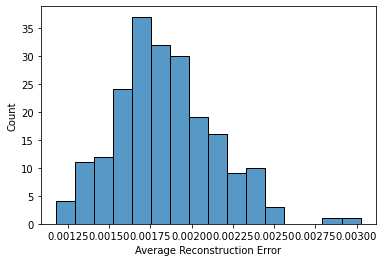

In [6]:
# Example of Histplot - for more plots see Plotting.ipynb
A = RE.reshape(20,-1,209).mean(axis=1)
df_opt_ae_4dim = pd.DataFrame(A[3], columns = ['Average Reconstruction Error'])
sns.histplot(data=df_opt_ae_4dim, x='Average Reconstruction Error')

In [7]:
np.save('df_opt_ae_RE_param', A)
np.save('opt_ae_MSE_TEST_param', MSE_TEST)
np.save('opt_ae_MSE_TRAIN_param', MSE_TRAIN)
np.save('df_opt_ae_OUT_TRAIN_param', output)
np.save('df_opt_ae_OUT_TEST_param', output_y)

In [10]:
%%time

# PCA Parameters

num = 25
dim = 20
test_size = 0.2
train_size = (1-test_size)*1042
ts = 1042 - train_size
pca_MSE_TRAIN = np.zeros((dim,num), dtype=float)
pca_MSE_TEST = np.zeros((dim,num), dtype=float)
pca_RE = np.zeros((dim, num, math.ceil(ts)), dtype=float)
repro_test = np.zeros((dim, num, int(ts), 388), dtype=float)

for comp in range(1,dim+1):
    print(f'\n\nCOMPONENT NUMBER {comp}')
    for i in range(num):
        print(f'\n\nTRIAL NUMBER {i}')
        X_train, X_test = train_test_split(scaleddf, test_size=test_size, shuffle=True)
        pca = PCA(n_components = comp)
        dim = pca.fit_transform(X_train)
        reprojected = pca.inverse_transform(dim)
        xvals2 = list(range(comp))
        print()
        print(pca.explained_variance_ratio_)

        dim_test = pca.transform(X_test)
        repro_test = pca.inverse_transform(dim_test)
    
        MSEtrain = mean_squared_error(X_train, reprojected)
        MSEtest = mean_squared_error(X_test, repro_test)
   
        print(MSEtrain)
        print(MSEtest)

        pca_MSE_TRAIN[comp-1][i] = MSEtrain
        pca_MSE_TEST[comp-1][i] = MSEtest
        pca_RE[comp-1][i] = ((repro_test[comp-1][i] - X_test)**2).mean(axis=1)
    


print(f'MSE TRAIN: {pca_MSE_TRAIN}\n\nMSE TEST: {pca_MSE_TEST}\n\n')
print(f'MSE TRAIN MEAN: {pca_MSE_TRAIN.mean(axis=1)}\n\nMSE TEST MEAN: {pca_MSE_TEST.mean(axis=1)}\n\n')

B = RE.reshape(20,-1,209).mean(axis=1)



COMPONENT NUMBER 1


TRIAL NUMBER 0

[0.59379456]
0.02771765991192379
0.02410138969924662


TRIAL NUMBER 1

[0.59566454]
0.02705557925737788
0.026712207217459313


TRIAL NUMBER 2

[0.59666599]
0.027133808861893514
0.026422467712961965


TRIAL NUMBER 3

[0.5977902]
0.027670355324366718
0.024270627070832274


TRIAL NUMBER 4

[0.60222967]
0.026935071874250812
0.027230730744001702


TRIAL NUMBER 5

[0.60992668]
0.026756386529513322
0.02805561729082279


TRIAL NUMBER 6

[0.59363649]
0.02730738906616797
0.025741328354237147


TRIAL NUMBER 7

[0.6063026]
0.02649941656302976
0.029123797088353227


TRIAL NUMBER 8

[0.59731434]
0.027708328408227418
0.024087254740297954


TRIAL NUMBER 9

[0.59379787]
0.027650411729746423
0.02437886321227386


TRIAL NUMBER 10

[0.59972218]
0.027263373940108453
0.025892625435277393


TRIAL NUMBER 11

[0.6006807]
0.02758790189649929
0.024584867690874646


TRIAL NUMBER 12

[0.59485232]
0.027568749676333854
0.024790618500643354


TRIAL NUMBER 13

[0.59028539]
0.0281

0.002873833261746921
0.002783782884798765


TRIAL NUMBER 21

[0.60049322 0.16179888 0.10330744 0.09298843]
0.0028280196522156584
0.002987837637211012


TRIAL NUMBER 22

[0.60524221 0.1601211  0.10006581 0.09171308]
0.0028523366725195847
0.002901966828336874


TRIAL NUMBER 23

[0.61043856 0.15374793 0.10159053 0.09317316]
0.002754456777347731
0.0033062333347564227


TRIAL NUMBER 24

[0.59422282 0.16226525 0.10405212 0.09685709]
0.0028979532419417605
0.0026877212382676458


COMPONENT NUMBER 5


TRIAL NUMBER 0

[0.59966716 0.15291582 0.10540527 0.10187395 0.01271299]
0.0018239578429759332
0.002412384738543215


TRIAL NUMBER 1

[0.60262293 0.15847215 0.10261706 0.09442867 0.01413062]
0.0018728930491554979
0.0021945072644089735


TRIAL NUMBER 2

[0.60445449 0.15708835 0.10513586 0.09122912 0.01385468]
0.0019021044691411768
0.002081889239214957


TRIAL NUMBER 3

[0.60721262 0.15623449 0.10361914 0.09034552 0.01438771]
0.0019242183230922946
0.0019905480451759107


TRIAL NUMBER 4

[0.5999654  

0.001111986731656364
0.000930272521345639


TRIAL NUMBER 14

[0.60118922 0.15756359 0.10433633 0.0942923  0.01335897 0.00698452
 0.00591032]
0.0011083088598620565
0.0009555737132438657


TRIAL NUMBER 15

[0.60672278 0.15840005 0.10293413 0.09186464 0.01380837 0.00668334
 0.00518019]
0.0009838353617175743
0.0015242871150814863


TRIAL NUMBER 16

[0.60675326 0.15235831 0.10391664 0.0938356  0.01326418 0.00740844
 0.00602807]
0.0011079317940103695
0.0009567408620914862


TRIAL NUMBER 17

[0.60509665 0.15117626 0.10374636 0.09824875 0.01331469 0.00709441
 0.00546981]
0.0010721124791525105
0.001151495294752755


TRIAL NUMBER 18

[0.6041226  0.15310294 0.10405876 0.09601934 0.01362183 0.00734216
 0.00552976]
0.0011067972577699493
0.0009578754107424318


TRIAL NUMBER 19

[0.60378826 0.15411138 0.10490437 0.09573217 0.01349474 0.00695885
 0.00571302]
0.0010366984971555897
0.0012412555385504784


TRIAL NUMBER 20

[0.60172089 0.15541085 0.10479513 0.09593271 0.01362234 0.00720103
 0.00541333]
0.

0.00047910469260109594
0.0009668519559007926


TRIAL NUMBER 20

[0.59690215 0.16162329 0.10188895 0.09534951 0.01423308 0.00750992
 0.00614132 0.00440426 0.00319331]
0.0005805447568036768
0.0004889691520581662


TRIAL NUMBER 21

[0.58726742 0.1575072  0.10796702 0.1057656  0.01370768 0.00739159
 0.00544327 0.0043182  0.00310165]
0.0005164760095822948
0.0007642559203852722


TRIAL NUMBER 22

[0.60400033 0.14665514 0.10671026 0.10222269 0.01351342 0.00634347
 0.00524395 0.0043044  0.00313683]
0.0005394109996258578
0.0006638414837790317


TRIAL NUMBER 23

[0.60769883 0.15563455 0.10357792 0.09046928 0.01329869 0.00730146
 0.00602115 0.00441894 0.0031976 ]
0.0005621301506877215
0.0005731254846417009


TRIAL NUMBER 24

[0.60268699 0.15573307 0.10361964 0.09761504 0.01373442 0.00662331
 0.005024   0.00435627 0.00314099]
0.0005048654589225733
0.0008160186282686705


COMPONENT NUMBER 10


TRIAL NUMBER 0

[0.60440645 0.15939205 0.10060232 0.09412559 0.01412527 0.00620256
 0.00559744 0.00414408 

0.0002735785296206103
0.00030925353829549927


TRIAL NUMBER 17

[0.60680113 0.14605038 0.10831    0.09662758 0.0132687  0.00737719
 0.00574358 0.0045455  0.00305399 0.0027035  0.00150987]
0.00027795094869865946
0.0003336453658872788


TRIAL NUMBER 18

[0.61150811 0.14502294 0.10698037 0.09605894 0.01220583 0.00696033
 0.00560356 0.00440955 0.00322046 0.00264211 0.001547  ]
0.000258936279625965
0.00038207125434818715


TRIAL NUMBER 19

[0.60682276 0.15373676 0.10326282 0.09533075 0.01319016 0.0067345
 0.00551025 0.00429946 0.00316418 0.00270029 0.00147028]
0.0002540188470983801
0.00039083397456897185


TRIAL NUMBER 20

[0.60731861 0.15656731 0.10232366 0.09068101 0.01343295 0.00740082
 0.00601461 0.00446716 0.00309151 0.00271019 0.00164813]
0.00029180867511916777
0.00022947310043703613


TRIAL NUMBER 21

[0.59515788 0.1602031  0.10555456 0.09510205 0.01366336 0.00790958
 0.00592099 0.00450895 0.00319664 0.00271859 0.00168892]
0.00029561613572040584
0.0002141965725196234


TRIAL NUMBER 2



TRIAL NUMBER 9

[0.60480611 0.15554516 0.10346005 0.09332888 0.01376274 0.00737426
 0.0057132  0.00443263 0.00313755 0.00267101 0.00166231 0.00133243
 0.00092634]
0.0001243019189025335
0.00014542892929091613


TRIAL NUMBER 10

[0.60413818 0.14930628 0.11047208 0.09540811 0.01199546 0.00742692
 0.00575434 0.0043493  0.0031184  0.00276917 0.00148338 0.00115042
 0.00080633]
0.00012396692504155604
0.0001531001251155301


TRIAL NUMBER 11

[0.59909382 0.16614441 0.10004538 0.09119859 0.01434873 0.0075997
 0.00581726 0.00445266 0.00316148 0.00260361 0.00167936 0.0012442
 0.00087187]
0.00011577177209310134
0.00019701408183056616


TRIAL NUMBER 12

[0.60710535 0.15449236 0.10264734 0.09505773 0.01332843 0.0070951
 0.005427   0.00425823 0.00316941 0.00269026 0.00133894 0.00088034
 0.00084114]
0.00011194951660218418
0.0002089819461722145


TRIAL NUMBER 13

[0.60283867 0.15598374 0.10496155 0.09354881 0.01341773 0.00728622
 0.00586387 0.00434581 0.00312352 0.0027802  0.00161812 0.00136947
 0.000


[0.60328223 0.15082456 0.10600857 0.09768979 0.01311593 0.0070551
 0.00576411 0.00442138 0.00309118 0.00270382 0.00168044 0.00147427
 0.00095752 0.00072927]
8.101271076808529e-05
7.929991466405816e-05


TRIAL NUMBER 23

[0.60124054 0.16119139 0.10326123 0.09422209 0.01376391 0.0064739
 0.00529046 0.00416351 0.00308425 0.00246309 0.0014267  0.00088743
 0.00084127 0.00064933]
6.983094837130655e-05
0.00013865770602952676


TRIAL NUMBER 24

[0.5982069  0.15744103 0.10402382 0.09929817 0.01305633 0.00705292
 0.00553354 0.00427623 0.00323107 0.00258045 0.00146964 0.00114665
 0.00088487 0.00068973]
7.45107612684463e-05
0.00011264985656587401


COMPONENT NUMBER 15


TRIAL NUMBER 0

[6.05986305e-01 1.53458989e-01 1.06438501e-01 9.08326109e-02
 1.37550016e-02 7.65039113e-03 5.81315219e-03 4.43972806e-03
 3.21946132e-03 2.74879564e-03 1.63628468e-03 1.28885540e-03
 9.43583861e-04 7.10416805e-04 3.90885509e-04]
4.610130049627331e-05
6.803015186723709e-05


TRIAL NUMBER 1

[6.01728520e-01 1.569565

3.859109905730903e-05
2.3972700464231804e-05


TRIAL NUMBER 1

[6.11084770e-01 1.48140677e-01 1.04991021e-01 9.36844659e-02
 1.27472196e-02 7.18125434e-03 5.77015831e-03 4.43316050e-03
 3.22302037e-03 2.71621298e-03 1.71318527e-03 1.46319554e-03
 9.47537184e-04 6.87632005e-04 4.61152521e-04 2.16502854e-04]
3.6545301604505744e-05
3.25566356520539e-05


TRIAL NUMBER 2

[6.05439170e-01 1.52097615e-01 1.04667969e-01 9.71120637e-02
 1.36317906e-02 6.71155568e-03 4.89767020e-03 4.16554930e-03
 3.14597986e-03 2.51802538e-03 1.60640371e-03 1.32904743e-03
 8.68299199e-04 6.70677781e-04 4.51328335e-04 2.04845191e-04]
3.2362056050622625e-05
5.2516723455816694e-05


TRIAL NUMBER 3

[5.97595310e-01 1.55642487e-01 1.06010166e-01 9.93047003e-02
 1.36902887e-02 6.99814202e-03 5.31025751e-03 4.35077065e-03
 3.15391815e-03 2.63745343e-03 1.44588559e-03 1.13301949e-03
 8.55030430e-04 6.91048583e-04 4.61127242e-04 2.13909977e-04]
3.497295132242179e-05
4.032638740228501e-05


TRIAL NUMBER 4

[5.99069182e-0


[6.03950856e-01 1.56203460e-01 1.04695531e-01 9.19908393e-02
 1.39986389e-02 7.36360935e-03 5.68001523e-03 4.50429445e-03
 3.07401126e-03 2.67943880e-03 1.60889705e-03 1.43357071e-03
 9.08630079e-04 7.05061623e-04 4.70551927e-04 2.14313583e-04
 1.68374724e-04]
2.4008312463347905e-05
2.7036775608288868e-05


TRIAL NUMBER 6

[6.06571610e-01 1.57123069e-01 1.02093230e-01 9.34647256e-02
 1.32958905e-02 7.01701194e-03 5.14798388e-03 4.14141671e-03
 3.27249195e-03 2.53713360e-03 1.55077303e-03 1.01603665e-03
 8.57443889e-04 7.24302802e-04 4.26990951e-04 2.20453207e-04
 1.71260016e-04]
2.457914840269336e-05
2.6005902708406715e-05


TRIAL NUMBER 7

[6.01106314e-01 1.50914781e-01 1.03863317e-01 1.00983553e-01
 1.36145701e-02 7.27799863e-03 6.09086470e-03 4.50988637e-03
 3.13765698e-03 2.65713381e-03 1.69364577e-03 1.32547908e-03
 9.54261939e-04 6.84806850e-04 4.67134779e-04 2.04081522e-04
 1.60505826e-04]
2.3972344950927872e-05
2.976539154761021e-05


TRIAL NUMBER 8

[6.12074320e-01 1.50471513


[6.06726421e-01 1.48721552e-01 1.07190211e-01 9.74598494e-02
 1.33175917e-02 6.34598763e-03 5.30809758e-03 4.30032084e-03
 3.09329887e-03 2.67052938e-03 1.31944490e-03 1.07577659e-03
 7.59290542e-04 6.13675647e-04 4.07369618e-04 2.01681879e-04
 1.57621753e-04 1.01699501e-04]
1.5751915795983086e-05
2.575944478703273e-05


TRIAL NUMBER 7

[6.08009301e-01 1.50422902e-01 1.04933421e-01 9.69224667e-02
 1.26369757e-02 6.58314083e-03 5.10137016e-03 4.24267132e-03
 3.24564013e-03 2.67408667e-03 1.44121851e-03 1.11040066e-03
 8.01206700e-04 7.02469924e-04 4.64703034e-04 2.10432055e-04
 1.51142876e-04 1.09968097e-04]
1.589012989689552e-05
2.112948226995161e-05


TRIAL NUMBER 8

[6.07590474e-01 1.55518343e-01 1.07301904e-01 8.64689275e-02
 1.36092917e-02 7.62973660e-03 6.04392229e-03 4.28894971e-03
 3.11310017e-03 2.67102453e-03 1.67202532e-03 1.32744156e-03
 9.12609976e-04 6.85384515e-04 4.39247667e-04 2.11374751e-04
 1.63778357e-04 1.15343296e-04]
1.6176688452642594e-05
2.236177400447239e-05




[5.95400543e-01 1.60595733e-01 1.04444015e-01 9.53488298e-02
 1.39094801e-02 7.62169224e-03 6.13077117e-03 4.48958613e-03
 3.18810228e-03 2.65515191e-03 1.72391401e-03 1.48323591e-03
 1.01395771e-03 7.45639449e-04 4.81956934e-04 2.05775592e-04
 1.74848543e-04 1.24537413e-04 9.11569341e-05]
1.1443041572338181e-05
9.791009911565478e-06


TRIAL NUMBER 7

[6.04263177e-01 1.54287463e-01 1.05733971e-01 9.38879929e-02
 1.31324832e-02 7.10659197e-03 5.45564256e-03 4.58209786e-03
 3.08356636e-03 2.66716580e-03 1.57604793e-03 1.40876572e-03
 8.97426022e-04 7.22272998e-04 4.59586748e-04 2.10845796e-04
 1.61012120e-04 1.20888274e-04 8.97009759e-05]
1.0429306198754304e-05
1.4218561729005341e-05


TRIAL NUMBER 8

[6.00847070e-01 1.59841535e-01 1.02513514e-01 9.36353305e-02
 1.39885357e-02 6.87468717e-03 5.95559827e-03 4.55346053e-03
 3.13240818e-03 2.71061799e-03 1.69638346e-03 1.39006880e-03
 9.49788491e-04 6.82592129e-04 4.74916854e-04 2.17693143e-04
 1.69862389e-04 1.15782342e-04 9.41242836e-05]

7.562744890498953e-06
8.620639843537276e-06


TRIAL NUMBER 6

[5.99069035e-01 1.61381987e-01 1.03183694e-01 9.41992309e-02
 1.38025009e-02 6.94870422e-03 5.69867561e-03 4.41674562e-03
 3.27124829e-03 2.79976606e-03 1.50591391e-03 1.15420679e-03
 8.04793643e-04 6.51613728e-04 4.40976765e-04 1.92448806e-04
 1.43014752e-04 1.06836743e-04 7.50551164e-05 4.97498870e-05]
6.960385496433768e-06
1.1065328578034515e-05


TRIAL NUMBER 7

[6.03153211e-01 1.49641150e-01 1.06516091e-01 9.73230950e-02
 1.36420107e-02 7.51109278e-03 5.96693811e-03 4.62173299e-03
 3.05614614e-03 2.68496111e-03 1.61830836e-03 1.44430859e-03
 9.36304382e-04 6.72420116e-04 4.61741646e-04 2.18193700e-04
 1.70253073e-04 1.07990512e-04 8.85634975e-05 5.11235432e-05]
7.89732557145282e-06
7.181487081332039e-06


TRIAL NUMBER 8

[6.03980469e-01 1.51301709e-01 1.03956464e-01 9.98269197e-02
 1.33045422e-02 6.86933065e-03 5.53959308e-03 4.42369233e-03
 3.15022010e-03 2.63575565e-03 1.34652897e-03 1.02457944e-03
 8.41944141e-04 6.8

In [11]:
np.save('df_opt_pca_RE_param', B)
np.save('opt_pca_MSE_TEST_param', pca_MSE_TEST)
np.save('opt_pca_MSE_TRAIN_param', pca_MSE_TRAIN)

In [12]:
print(B)

[[0.00986897 0.00674398 0.00533818 ... 0.00506097 0.00638213 0.00784817]
 [0.00138845 0.00173198 0.00200635 ... 0.00207855 0.00162966 0.00165628]
 [0.00155484 0.0013709  0.00163205 ... 0.00118789 0.00153803 0.00225523]
 ...
 [0.00166112 0.00136989 0.0014998  ... 0.00144829 0.00163101 0.00153436]
 [0.0015687  0.00122943 0.00122606 ... 0.00115988 0.00114728 0.00111689]
 [0.00160811 0.00156802 0.00207438 ... 0.00164939 0.00212575 0.00200996]]
